### 數據: Disasters on social media
在分類社交媒體上的評論有兩種<br>
第1種是與災難、暴亂無關的評論<br>
第2種是有關災難、暴亂的評的評論
* bag of words
* TFIDF
* word2vector

### 請解壓縮data.rar，取得本程式之數據

In [1]:
import warnings
warnings.filterwarnings('ignore')
import keras
import nltk
import pandas as pd
import numpy as np
import re
import os
import matplotlib
import matplotlib.patches as mpatches
import itertools

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
questions = pd.read_csv('socialmedia_relevant_cols_clean.csv')
questions.columns=['text' , 'choose_one' , 'class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [3]:
# 數據清理，去掉沒用的字母
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+" , "")
    df[text_field] = df[text_field].str.replace(r"http" , "")
    df[text_field] = df[text_field].str.replace(r"@\S+" , "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]" , " ")
    df[text_field] = df[text_field].str.replace(r"@" , "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = clean_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [4]:
clean_questions = pd.read_csv('clean_data.csv')
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10871,10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1
10872,10872,police investigating after an e bike collided ...,Relevant,1
10873,10873,the latest more homes razed by northern calif...,Relevant,1
10874,10874,meg issues hazardous weather outlook (hwo),Relevant,1
10875,10875,cityofcalgary has activated its municipal eme...,Relevant,1


### 看一下數據分布情况，檢查label是否均衡(看起来還算的)

In [5]:
for i , j in enumerate(clean_questions.groupby('class_label')):
    print('class_label {} count : {}'.format(i , j[1]['class_label'].count()))     # class_label:2 不知道是什麼類別的(不重要)

class_label 0 count : 6187
class_label 1 count : 4673
class_label 2 count : 16


### 處理流程

- 分詞
- 訓練與測試集
- 檢查與驗證

In [6]:
tokenizer = RegexpTokenizer('\w+')
clean_questions['tokens'] = clean_questions['text'].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


### corpus的情况

In [7]:
all_words = [] # 將clean_questions['tokens']所有詞都收集起來
for tokens in clean_questions['tokens']:
    for word in tokens:
        all_words.append(word)
sentence_lengths = [len(tokens) for tokens in clean_questions['tokens']]
vocab = sorted(list(set(all_words)))

print('total word : {}'.format(len(all_words)))
print('vocabulary size : {}'.format(len(vocab)))
print('max sentence length :{}'.format(max(sentence_lengths)))

total word : 154724
vocabulary size : 18101
max sentence length :34


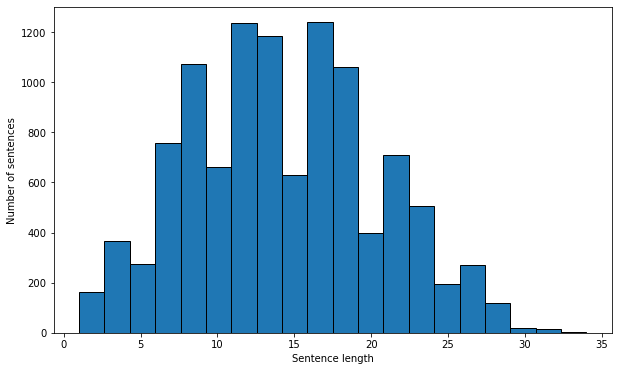

In [10]:
# 句子長度的分布情況
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10 , 6)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths , bins = 20 , edgecolor = 'black')
plt.show()

In [11]:
list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

# 先分為訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(list_corpus,
                                                    list_labels, 
                                                    test_size = 0.2,
                                                    random_state = 40)

## Bag of Words Counts

In [12]:
def cv(data , feature = None):
    count_vectorizer = CountVectorizer(max_features = feature) # max_features = N -> 可降低每個詞的向量維度
    emb = count_vectorizer.fit_transform(data)
    return emb , count_vectorizer

# X_train_counts.shape = 8700x16046 ， 代表有8700個句子，若其中的句子出現'my'、'pen'，
# 那就會在16046維的向量中的'my'、'pen'的欄位出現1，若句子中有重複'my'這個詞 N 次的話，那在'my'這個欄位就是 N
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [13]:
# clean_questions['tokens']的元素裏頭都有數個字，現在就是要把每個元素裏頭的每個字對應的向量記錄下來，這些向量輸入RNN做分析
# 用這種方式將每個字轉換成向量是非常粗糙的作法，建議使用word2vector的方式(自己訓練或拿別人訓練好的都可以)將字轉換成向量

vocab_sparse , _ = cv(vocab , 5000)  # max_features = 5000 -> 可降低每個詞的向量維度
vocab_array = vocab_sparse.toarray() # 將sparse matrix 轉為普通 matrix
vocab_array_list = []
for i in range(0 , len(vocab_array)):
    vocab_array_list.append(vocab_array[i , :])

vocab = dict(zip(vocab , vocab_array_list))    

# 把clean_questions['tokens']每個元素(每個句子)中的詞按照順序轉換成向量，一句句子就會變成一個矩陣 => [seq_size , embed_size]
# 所有clean_questions['tokens']所有元素(所有句子)累積起來就會變成一個三維矩陣 => [num of sesentence , seq_size , embed_size]
sentence_array_list = [] 
for tokens in clean_questions['tokens']: 
    temp_array = vocab[tokens[0]].reshape(1 , -1)
    for i , word in enumerate(tokens):
        temp_array = np.concatenate([temp_array , vocab[word].reshape(1 , -1)] , axis = 0)       
    sentence_array_list.append(temp_array)  

### 降維展示Bag of Words的每一句句子的向量投影在2維平面上的情況

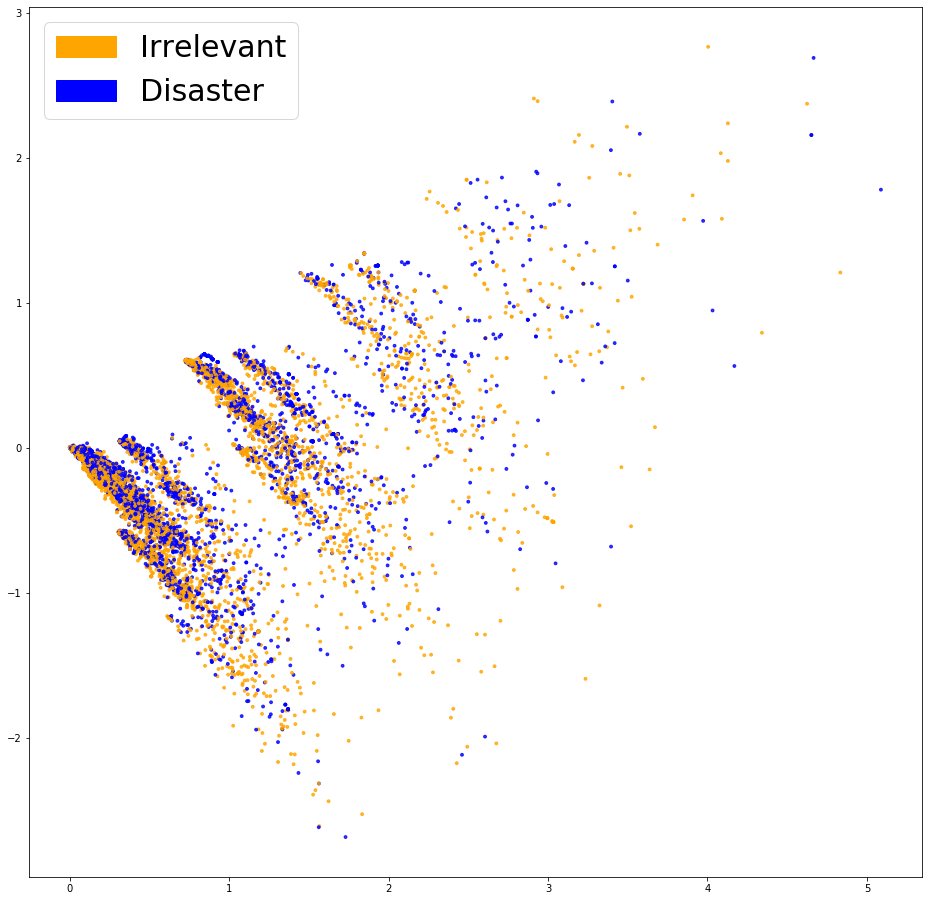

In [16]:
def plot_LSA(test_data , test_labels , plot=True):
    lsa = TruncatedSVD(n_components = 2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
#     color_mapper = {label:idx for idx,label in enumerate(set(test_labels))} 
#     color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange' , 'blue']
    if plot:
        plt.scatter(lsa_scores[: , 0] , lsa_scores[: , 1] , 
                    s = 8 , alpha = 0.8 , c = test_labels , cmap = matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color = 'orange' , label = 'Irrelevant')
        green_patch = mpatches.Patch(color = 'blue' , label = 'Disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

fig = plt.figure(figsize = (16, 16))          
plot_LSA(X_train_counts , y_train)
plt.show()

看起来並沒有將兩類區分開

### 用邏輯回歸預測Bag of Words的結果

In [17]:
clf = LogisticRegression(C = 30.0 ,
                         class_weight = 'balanced' , 
                         solver = 'newton-cg', 
                         multi_class = 'multinomial' ,
                         n_jobs = -1)

clf.fit(X_train_counts , y_train)
y_predicted_counts = clf.predict(X_test_counts)

### 評估分類結果

In [19]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy , precision , recall , f1 = get_metrics(y_test, y_predicted_counts)
print('accuracy = {:.2%} , precision = {:.2f} , recall = {:.2f} , f1 = {:.2f}'.format(accuracy , precision , recall , f1))

accuracy = 75.37% , precision = 0.75 , recall = 0.75 , f1 = 0.75


### 觀看confusion_matrix

In [20]:
def plot_confusion_matrix(cm , classes ,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

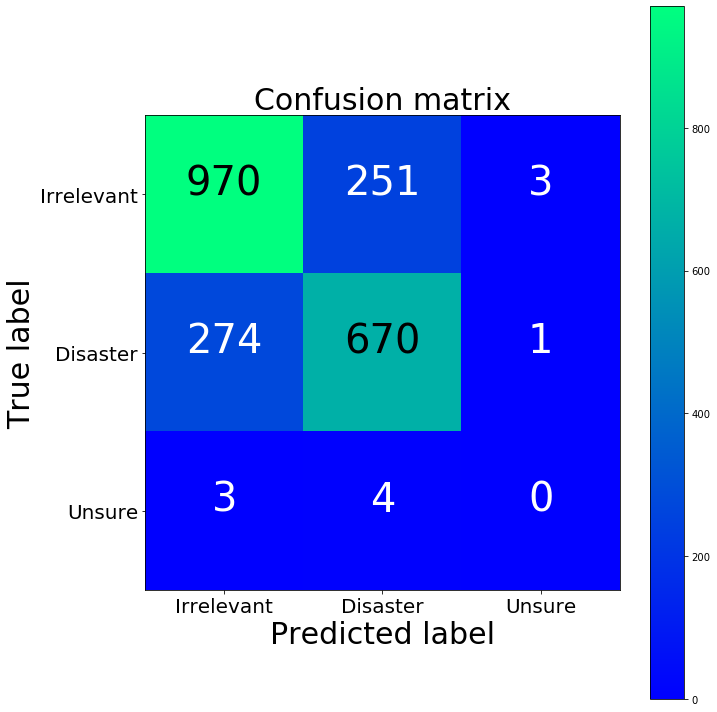

In [21]:
cm = confusion_matrix(y_test , y_predicted_counts)
fig = plt.figure(figsize=(10 , 10))
plot = plot_confusion_matrix(cm , classes = ['Irrelevant' , 'Disaster' , 'Unsure'] , normalize = False , title = 'Confusion matrix')
plt.show()

沒有預測出任何第三類，因為數據裡面屬於第三類的label的非常少

### 看看每一個詞對於結果所佔的權重
### 總共有3種分類，共有16046個詞，所以每種分類都有16046個權重 
### y_pred = w₁ ✕ word₁ + ... + w₁₆₀₄₆ ✕ word₁₆₀₄₆
### 現在就是要看每一個分類中哪一些詞的權重(絕對值)比較大

In [22]:
def get_most_important_features(vectorizer , model , n = 10):
    index_to_word = dict(zip(vectorizer.vocabulary_.values() , vectorizer.vocabulary_.keys()))
    classes ={}
    for class_index in range(0 , model.coef_.shape[0]):
        word_importances = []
        # word_importances => 在一個分類中收集每一個字的權重
        for i , weight in enumerate(model.coef_[class_index]):
            word_importances.append((weight , index_to_word[i]))

        score , item = [] , []
        for i in range(0 , len(word_importances)):
            score.append(word_importances[i][0])
            item.append(word_importances[i][1])

        temp = pd.DataFrame([item , score]).T
        temp.columns = ['item' , 'score'] 
        temp.sort_values(by = 'score' , inplace = True)
        temp = temp.reset_index(drop = True)
        classes[class_index] = {'tops' : temp.tail(n),    # 從分數最高的挑n個
                                'bottom' : temp.head(n)}  # 從分數最低的挑n個 
    return classes

importance = get_most_important_features(count_vectorizer , clf , 10)

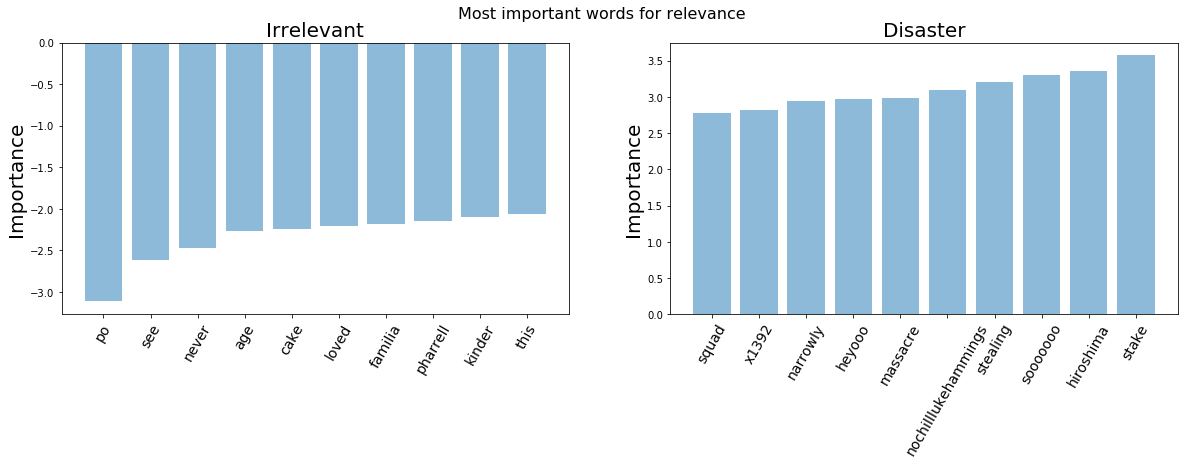

In [29]:
def plot_important_words(top_scores , top_words , bottom_scores , bottom_words, name):
    x_pos = np.arange(len(top_words))
    fig = plt.figure(figsize = (20 , 5))  

    plt.subplot(121)
    plt.bar(x_pos , bottom_scores , align = 'center' , alpha = 0.5)
    plt.title('Irrelevant' , fontsize = 20)
    plt.xticks(x_pos , bottom_words , fontsize = 14 , rotation = 60)
    plt.ylabel('Importance' , fontsize = 20)

    plt.subplot(122)
    plt.bar(x_pos , top_scores , align = 'center' , alpha = 0.5)
    plt.title('Disaster' , fontsize = 20)
    plt.xticks(x_pos , top_words , fontsize = 14 , rotation = 60)
    plt.ylabel('Importance' , fontsize = 20)
    
    plt.suptitle('Most important words for relevance' , fontsize = 16)
    plt.subplots_adjust(wspace = 0.2)
    plt.show()

# 看第2個分類前10個字的權重結果
top_words , top_scores , bottom_words , bottom_scores = [] , [] , [] , []
for i in range(0 , importance[1]['tops'].shape[0]):
    top_words.append(importance[1]['tops'].iloc[i , 0]) 
    top_scores.append(importance[1]['tops'].iloc[i , 1])

for i in range(0 , importance[1]['bottom'].shape[0]):
    bottom_words.append(importance[1]['bottom'].iloc[i , 0]) 
    bottom_scores.append(importance[1]['bottom'].iloc[i , 1])

plot_important_words(top_scores , top_words, bottom_scores , bottom_words , 'Most important words for relevance')

模型找到了一些模式，但是看起來還不夠好

### TFIDF 
假如有一篇文章<台灣蜜蜂養殖>出現大量的「台灣」與「蜜蜂」，這兩個詞在這篇文章出現的次數都一樣多<br>
假如其他文章出現非常多「台灣的牛」、「台灣的豬」、「台灣的羊」等等，而沒有出現「蜜蜂」<br>
此時若使用word of bags，「台灣」這個詞的重要性會比「蜜蜂」還高<br>
但TFIDF會針對corpus中所有的文章去計算這兩個詞的權重<br>
因為「台灣」這個詞在其他文章大量出現，所以重要性就會被拉低<br>
"蜜蜂"這個詞出現的次數雖然比較少，但只有在一篇文章中大量出現，所以這個詞就會被賦予較高的重要性

In [30]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train , tfidf_vectorizer

X_train_tfidf , tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

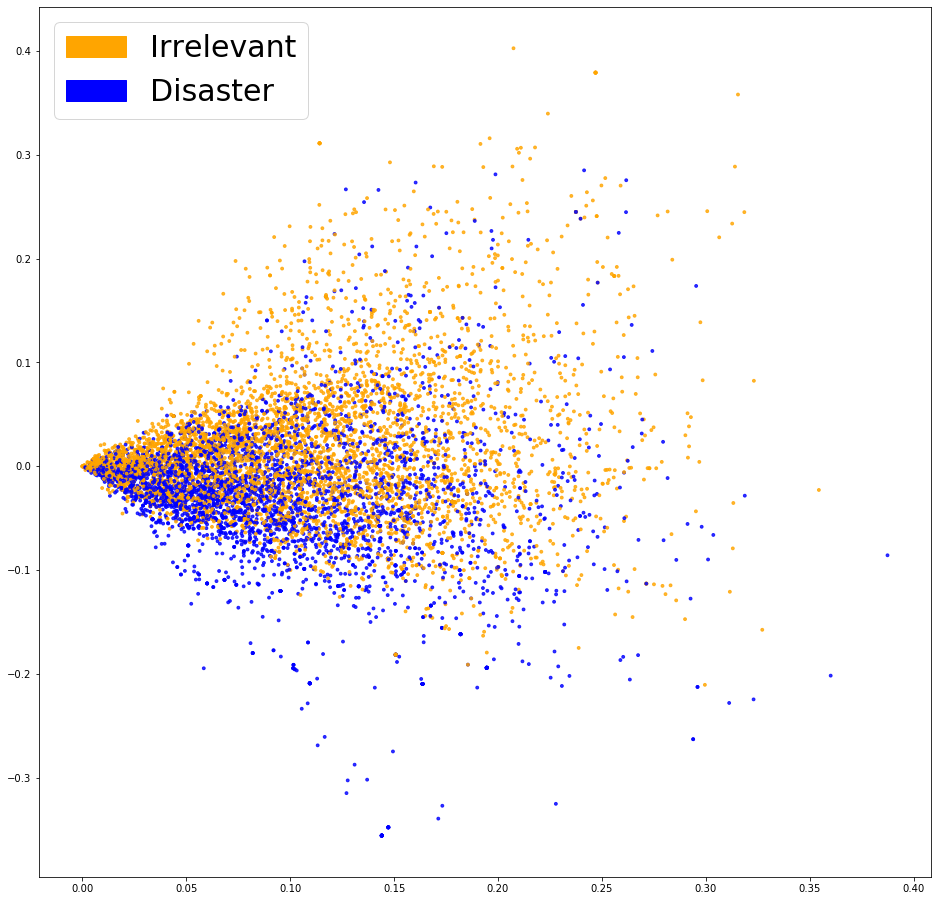

In [31]:
fig = plt.figure(figsize = (16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

從投影在2維平面的結果看起來 TFIDF 比 Bag of Words 好那麼一丁點

In [32]:
clf_tfidf = clf = LogisticRegression(C = 30.0 ,
                         class_weight = 'balanced' , 
                         solver = 'newton-cg', 
                         multi_class = 'multinomial' ,
                         n_jobs = -1)

clf_tfidf = LogisticRegression(C = 30.0 ,
                               class_weight = 'balanced' , 
                               solver = 'newton-cg', 
                               multi_class = 'multinomial' ,
                               n_jobs = -1)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print('accuracy = {:.2%} , precision = {:.2f} , recall = {:.2f} , f1 = {:.2f}'.format(accuracy_tfidf , precision_tfidf , recall_tfidf , f1_tfidf))

accuracy = 76.19% , precision = 0.76 , recall = 0.76 , f1 = 0.76


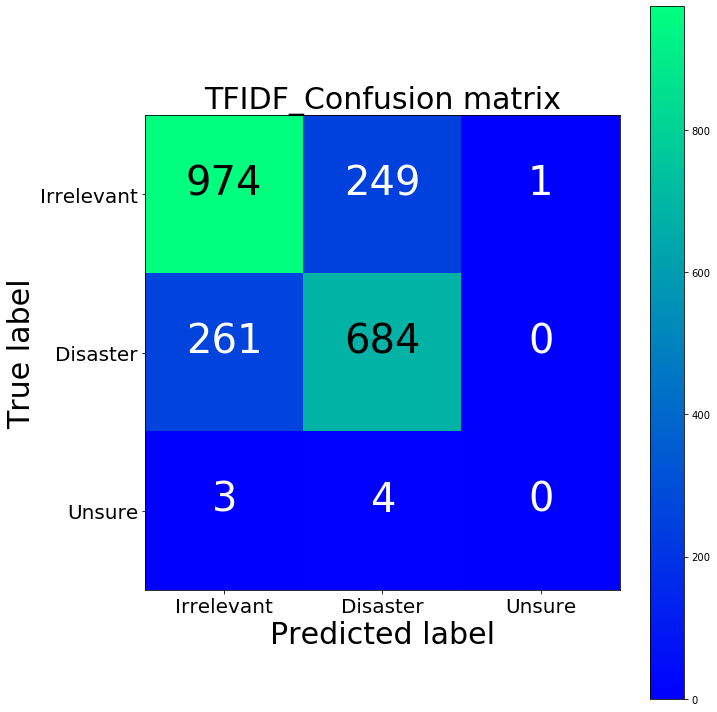

In [33]:
cm_tfidf = confusion_matrix(y_test , y_predicted_tfidf)
fig = plt.figure(figsize = (10 , 10))
plot = plot_confusion_matrix(cm_tfidf, classes = ['Irrelevant' , 'Disaster' , 'Unsure'] , normalize = False , title = 'TFIDF_Confusion matrix')
plt.show()

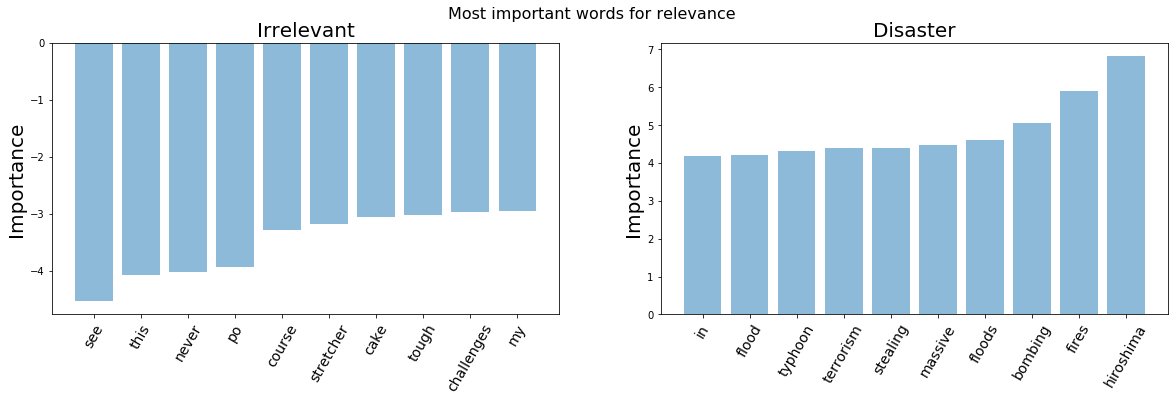

In [34]:
importance_tfidf = get_most_important_features(tfidf_vectorizer , clf_tfidf , 10)

# 看第2個分類前10個字的權重結果
top_words , top_scores , bottom_words , bottom_scores = [] , [] , [] , []
for i in range(0 , importance_tfidf[1]['tops'].shape[0]):
    top_words.append(importance_tfidf[1]['tops'].iloc[i , 0]) 
    top_scores.append(importance_tfidf[1]['tops'].iloc[i , 1])

for i in range(0 , importance_tfidf[1]['bottom'].shape[0]):
    bottom_words.append(importance_tfidf[1]['bottom'].iloc[i , 0]) 
    bottom_scores.append(importance_tfidf[1]['bottom'].iloc[i , 1])
    
plot_important_words(top_scores, top_words, bottom_scores , bottom_words , 'Most important words for relevance')    

這些詞看起來似乎比bag of words好一點!!

### 問題
我們現在考慮的是每一個詞基於頻率的情況，如果在新的文章下有些詞改變了呢？<br>
比如說goog和positive有些詞可能表達的意義差不多，但是卻長得不一樣，上面兩個模型無法解決這樣的問題

### word2vec
可以把每個詞映射成N維向量<br>
屌打bag of words 與 TFIDF

In [36]:
# 可把每個詞轉成300維的向量
# 雖然可以自己訓練，但這裡直接抓google的來用
f = open(os.path.join('glove.6B.300d.txt') , encoding = 'utf-8') 
embeddings_index = {}
while True:
    line = f.readline()
    if len(line) == 0 : break
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1 : ] , dtype = 'float32')
    embeddings_index[word] = coefs

In [37]:
# 假如一句句有50個字，就把這50個字轉成向量，接著再把這個50個字的向量加起來平均
# 這是現階段的作法，若用NN來做就不需要平均了
generate_missing = False
k = 300
embeddings = []
for i in range(0 , len(clean_questions['tokens'])):
    
    tokens_list = clean_questions['tokens'][i]

    if len(tokens_list) < 1:averaged = np.zeros(k)
        
    vectorized = []
    if generate_missing:
        for word in tokens_list:
            if word in embeddings_index.keys():
                vectorized.append(embeddings_index[word])
            elif word not in embeddings_index.keys(): 
                vectorized.append(np.random.rand(k)) 
    else:
        for word in tokens_list:
            if word in embeddings_index.keys(): 
                vectorized.append(embeddings_index[word])
            elif word not in embeddings_index.keys():  
                vectorized.append(np.zeros(k)) 
                
    length = len(vectorized)
    summed = np.sum(vectorized , axis = 0)
    averaged = np.divide(summed , length)

    embeddings.append(averaged)

In [38]:
X_train_word2vec , X_test_word2vec , y_train_word2vec , y_test_word2vec = train_test_split(embeddings ,
                                                                                            list_labels , 
                                                                                            test_size = 0.2)
X_train_word2vec[0]

array([-1.02241114e-01,  1.20661221e-01, -6.20476417e-02, -1.14950657e-01,
       -1.17795058e-01,  7.18151182e-02, -1.01325504e-01,  2.85719195e-03,
        3.78407501e-02, -1.65026605e+00,  1.38381466e-01, -3.82699980e-03,
       -9.88975465e-02,  7.95421675e-02,  3.21458541e-02,  2.20247492e-01,
       -1.74175411e-01,  1.35759152e-02, -6.87099174e-02, -1.17901906e-01,
        6.87906817e-02,  1.46674097e-01,  1.97456270e-01,  9.76683795e-02,
       -2.30325401e-01, -9.62835625e-02,  6.71813264e-02, -7.92079121e-02,
       -1.32010639e-01,  1.28208511e-02, -1.56064201e-02,  1.29086122e-01,
       -1.55846611e-01,  1.28254592e-01, -8.74099851e-01, -1.71998079e-04,
       -3.09307594e-02,  4.16001081e-02, -1.85033455e-01, -4.31062616e-02,
        7.04751816e-03, -1.28674880e-01, -1.02422833e-01,  1.79510772e-01,
        1.00399382e-01,  1.15654618e-01,  4.26857397e-02,  1.88456148e-01,
       -9.95445326e-02,  4.17919904e-02,  8.84565413e-02, -7.21035302e-02,
       -2.83774994e-02, -

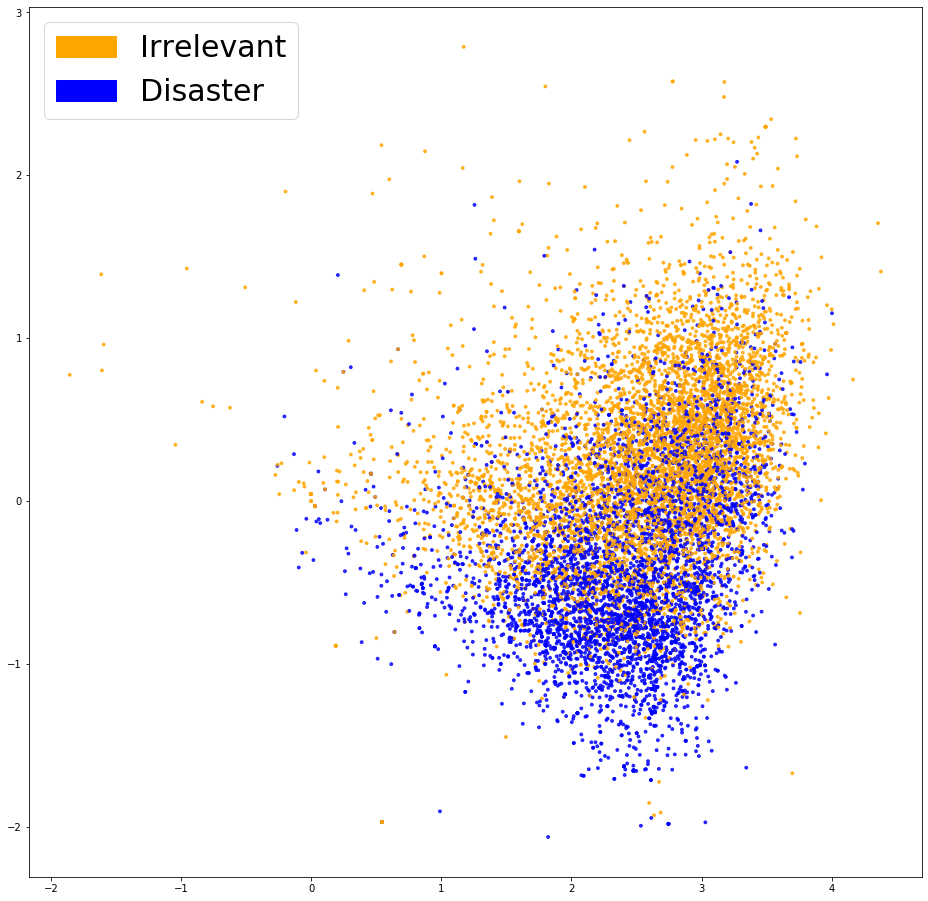

In [39]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

看起來比 TFIDF 與 Bag of Words好一些了

In [40]:
clf_w2v = LogisticRegression(C = 30.0 ,
                             class_weight = 'balanced' , 
                             solver = 'newton-cg', 
                             multi_class = 'multinomial' ,
                             n_jobs = -1)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [41]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print('accuracy = {:.2%} , precision = {:.2f} , recall = {:.2f} , f1 = {:.2f}'.format(accuracy_word2vec , precision_word2vec , recall_word2vec , f1_word2vec))

accuracy = 77.44% , precision = 0.77 , recall = 0.77 , f1 = 0.77


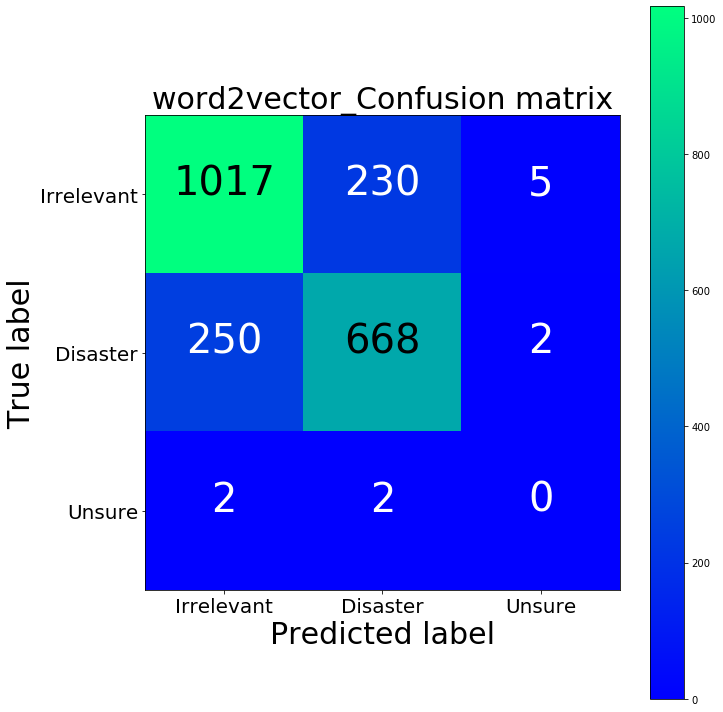

In [42]:
cm_w2v = confusion_matrix(y_test_word2vec , y_predicted_word2vec)
fig = plt.figure(figsize = (10 , 10))
plot = plot_confusion_matrix(cm_w2v, classes = ['Irrelevant' , 'Disaster' , 'Unsure'] , normalize = False , title = 'word2vector_Confusion matrix')
plt.show()

word2vector看起來的效果比前面兩種方法都好<br>
在word2vector中，由於已經將所有的詞以300維的向量做表示，所以無法在看到每一個分類中，每個詞的重要程度